In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install joblib

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
drive_path = "/content/gdrive/MyDrive/AndElementTask"

Mounted at /content/gdrive


Loading Dataset

In [ ]:
df = pd.read_csv(drive_path+'/spam.csv',encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removing unnecessary columns

In [ ]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

Handling missing values

In [ ]:
df.isna().sum()

,0
v1,0
v2,0


In [ ]:
df.rename(columns={'v1':'label','v2':'message'},inplace=True)

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Handling duplicates

In [ ]:
df.duplicated().sum()

403

In [ ]:
df[df.duplicated(keep='first')].head()

,label,message
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls


In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.duplicated().sum()

0

Function for cleaning and processing text

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing data

In [ ]:
df_cleaned = df.copy()
df_cleaned['message'] = [preprocess_text(df_cleaned['message'][i]) for i in range(len(df_cleaned))]

In [ ]:
df_cleaned.head()

,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though


Checking for class imbalance

label
0    4516
1     653
Name: count, dtype: int64


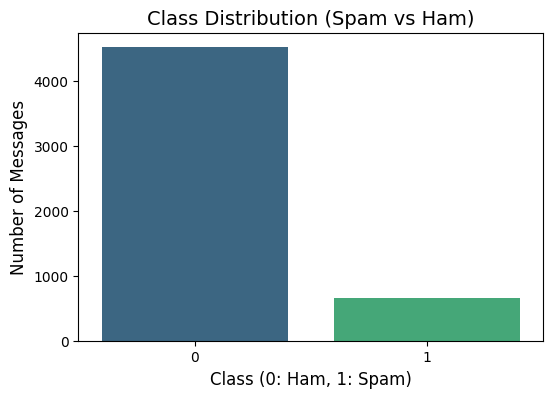

In [ ]:
# Check for class imbalance
label_counts = df_cleaned['label'].value_counts()
print(label_counts)
# Plot the class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Set plot labels and title
plt.title('Class Distribution (Spam vs Ham)', fontsize=14)
plt.xlabel('Class (0: Ham, 1: Spam)', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)

# Show the plot
plt.show()

Splitting dataset into train and test

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['message'], df_cleaned['label'], test_size=0.2, random_state=42, stratify=df_cleaned['label'])

Further splitting dataset into train and validation

In [ ]:
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

#Functions to train and evaluate models

In [ ]:
def compute_performance(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate recall (macro)
    recall_macro = recall_score(y_true, y_pred, average='macro')

    # Calculate precision (macro)
    precision_macro = precision_score(y_true, y_pred, average='macro')

    # Calculate F1 score (macro)
    score = f1_score(y_true, y_pred, average='macro')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print results
    print("Accuracy:", accuracy)
    print("Recall (macro):", recall_macro)
    print("Precision (macro):", precision_macro)
    print("F1 (macro):", score)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    return score

def evaluate_model(pipeline, X_test,y_test):
  # Make predictions on the test set
  y_pred = pipeline.predict(X_test)
  compute_performance(y_test, y_pred)

def grid_search(pipeline,X_train = X_train,y_train = y_train,param_grid = {}):
  stratified_cv = StratifiedKFold(n_splits=5)
  # Initialize GridSearchCV
  grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_cv, scoring='f1_macro', verbose=2,error_score='raise')
  grid_search.fit(X_train, y_train)
  # Best parameters
  print("Best parameters found: ", grid_search.best_params_)
  return grid_search.best_estimator_

# Training ML models using Grid Search for parameters tunning

Logistic Regression

Logistic Regression
Without SMOTE
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
Best parameters found:  {}
Accuracy: 0.9649334945586457
Recall (macro): 0.9140866049579742
Precision (macro): 0.9246242806098792
F1 (macro): 0.9192613913716776


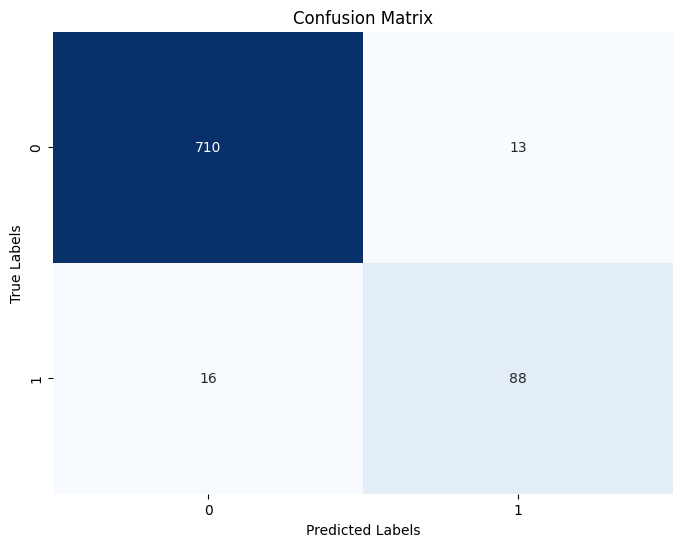

With SMOTE
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best parameters found:  {}
Accuracy: 0.9649334945586457
Recall (macro): 0.9099704755825088
Precision (macro): 0.9277181152181152
F1 (macro): 0.918578320370188


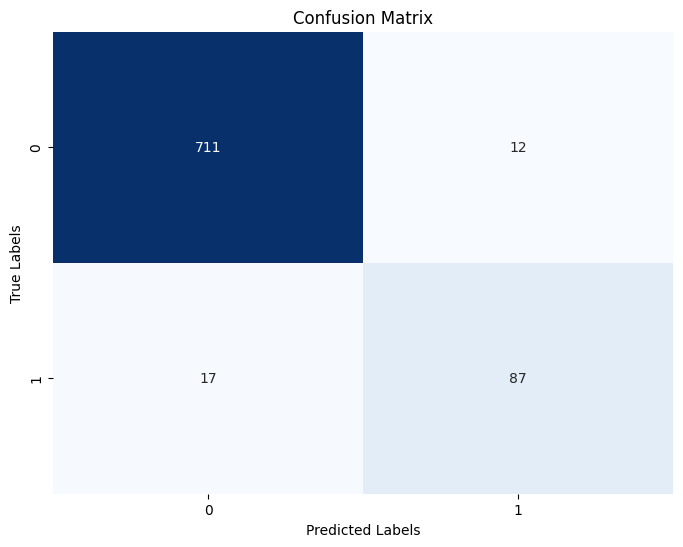

In [ ]:
print("Logistic Regression")
print("Without SMOTE")
lr_model = Pipeline([('vect',TfidfVectorizer()),
                    ('clf',LogisticRegression(class_weight='balanced'))])
lr_model = grid_search(lr_model)
evaluate_model(lr_model,X_valid,y_valid)

print("With SMOTE")
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

lr_model_smote = LogisticRegression()
lr_model_smote = grid_search(lr_model_smote,X_resampled, y_resampled)

evaluate_model(lr_model_smote,X_valid_tfidf,y_valid)

Multinomial Naive Bayes

Multinomial Naive Bayes
Without SMOTE
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.1s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.1s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.1s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.1s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.1s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.1s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.1s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.1s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.1s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.1s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   0.1s
[CV] END .

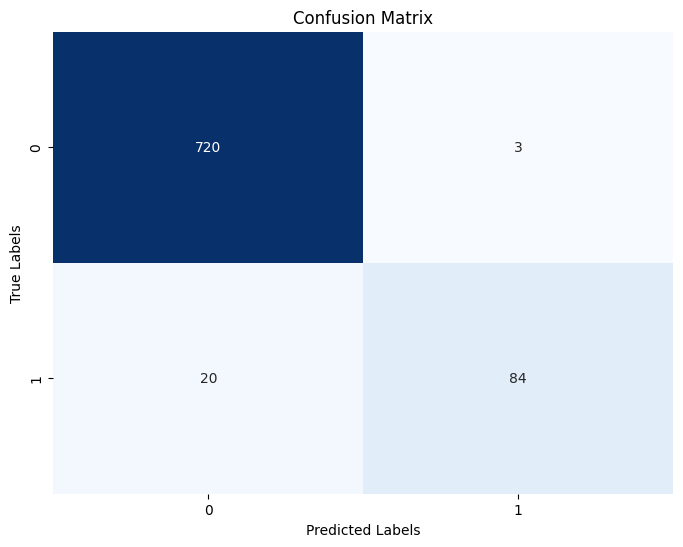

With SMOTE
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................al

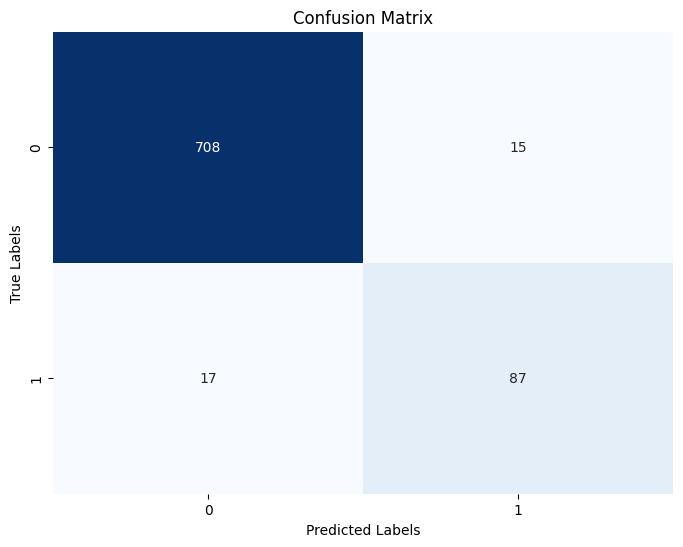

In [ ]:
print("Multinomial Naive Bayes")
print("Without SMOTE")
nb_model = Pipeline([('vect',TfidfVectorizer()),
                    ('clf',MultinomialNB())])
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'clf__fit_prior': [True, False]
}
nb_model = grid_search(nb_model,param_grid=param_grid)
evaluate_model(nb_model,X_valid,y_valid)

print("With SMOTE")
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}
nb_model_smote = MultinomialNB()
nb_model_smote = grid_search(nb_model_smote,X_resampled, y_resampled, param_grid)

evaluate_model(nb_model_smote,X_valid_tfidf,y_valid)


Random Forest Classifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=   0.5s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=   0.5s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=   0.5s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=   0.5s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=   0.5s
[CV] END .........clf__max_depth=None, clf__n_estimators=100; total time=   1.0s
[CV] END .........clf__max_depth=None, clf__n_estimators=100; total time=   1.0s
[CV] END .........clf__max_depth=None, clf__n_estimators=100; total time=   1.0s
[CV] END .........clf__max_depth=None, clf__n_estimators=100; total time=   1.0s
[CV] END .........clf__max_depth=None, clf__n_estimators=100; total time=   1.5s
[CV] END .........clf__max_depth=None, clf__n_estimators=150; total time=   2.0s
[CV] END .........clf__max_depth=None, clf__n_es

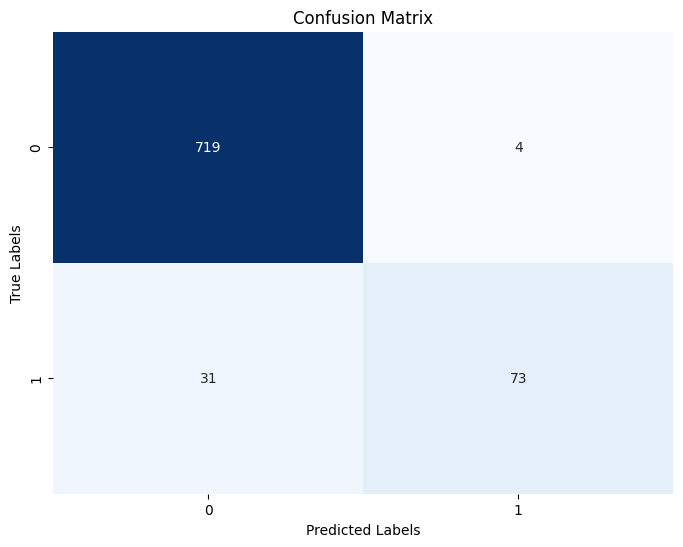

With SMOTE
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   1.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   2.0s
[CV] END ....................max_depth=None, n_estimators=50; total time=   4.0s
[CV] END ....................max_depth=None, n_estimators=50; total time=   3.5s
[CV] END ....................max_depth=None, n_estimators=50; total time=   2.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   3.4s
[CV] END ...................max_depth=None, n_estimators=100; total time=   4.4s
[CV] END ...................max_depth=None, n_estimators=100; total time=   6.7s
[CV] END ...................max_depth=None, n_estimators=100; total time=   6.5s
[CV] END ...................max_depth=None, n_estimators=100; total time=   6.5s
[CV] END ...................max_depth=None, n_estimators=150; total time=   4.7s
[CV] END ...................max_depth

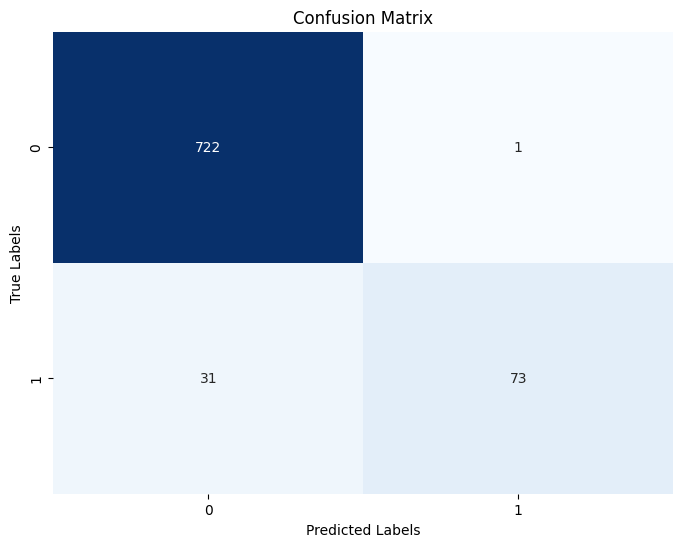

In [ ]:
rf_model = Pipeline([('vect',TfidfVectorizer()),
                    ('clf',RandomForestClassifier(class_weight='balanced'))])
param_grid = {
    'clf__n_estimators': [50, 100,150],
    'clf__max_depth': [None, 10, 20,30],
}
rf_model = grid_search(rf_model,param_grid=param_grid)
evaluate_model(rf_model,X_valid,y_valid)

print("With SMOTE")
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
param_grid = {
    'n_estimators': [50, 100,150],
    'max_depth': [None, 10, 20,30]
}
rf_model_smote = RandomForestClassifier()
rf_model_smote = grid_search(rf_model_smote,X_resampled, y_resampled, param_grid)

evaluate_model(rf_model_smote,X_valid_tfidf,y_valid)

# Evaluating on Test data

Logistic Regression

Logistic Regression - Without SMOTE
Accuracy: 0.9709864603481625
Recall (macro): 0.9344424437625218
Precision (macro): 0.9344424437625218
F1 (macro): 0.9344424437625218


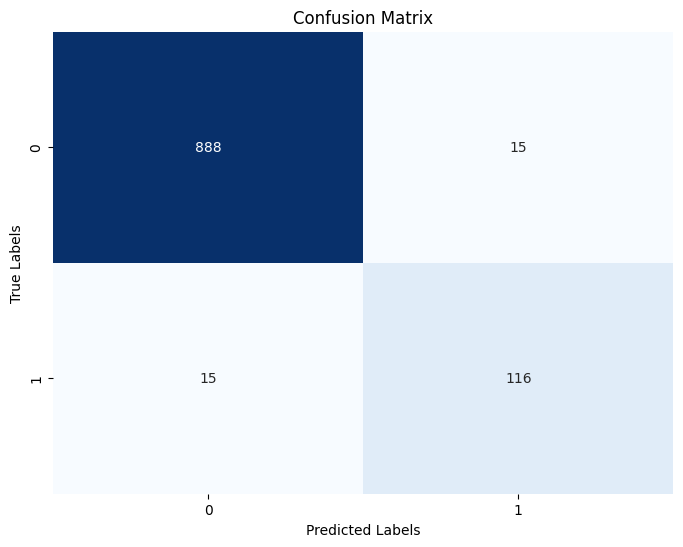

Logistic Regression - With SMOTE
Accuracy: 0.971953578336557
Recall (macro): 0.931733069581463
Precision (macro): 0.9403887279249448
F1 (macro): 0.9359999658507121


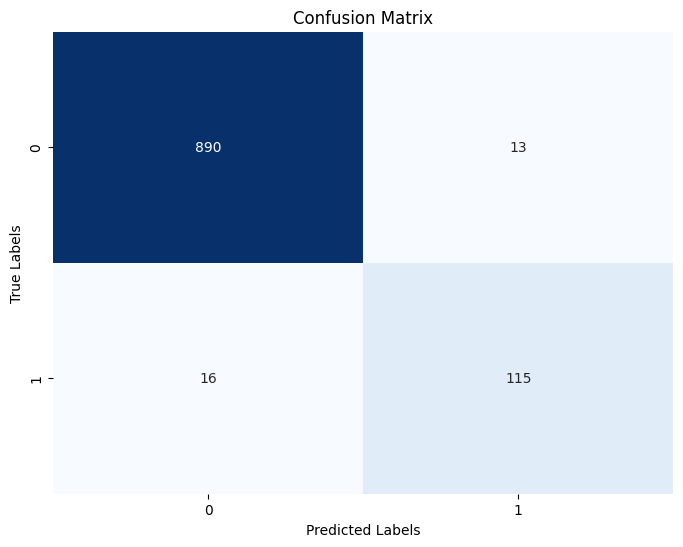

0.9359999658507121

In [ ]:
# Make predictions on the test set
print("Logistic Regression - Without SMOTE")
y_pred = lr_model.predict(X_test)
compute_performance(y_test, y_pred)
print("Logistic Regression - With SMOTE")
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = lr_model_smote.predict(X_test_tfidf)
compute_performance(y_test, y_pred)

Multinomial Naive Bayes

Multinomial Naive Bayes - Without SMOTE
Accuracy: 0.9796905222437138
Recall (macro): 0.9296365803555577
Precision (macro): 0.9772650439486139
F1 (macro): 0.9517238159395447


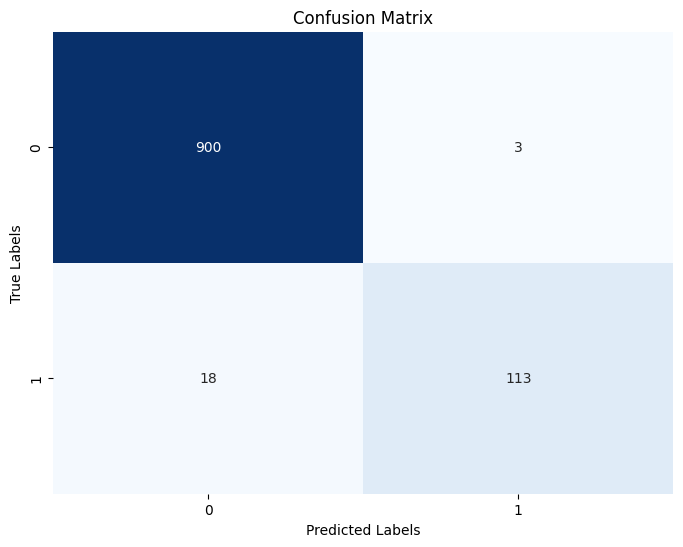

Multinomial Naive Bayes - With SMOTE
Accuracy: 0.965183752417795
Recall (macro): 0.9278571005892149
Precision (macro): 0.9170271495076834
F1 (macro): 0.9223419258468035


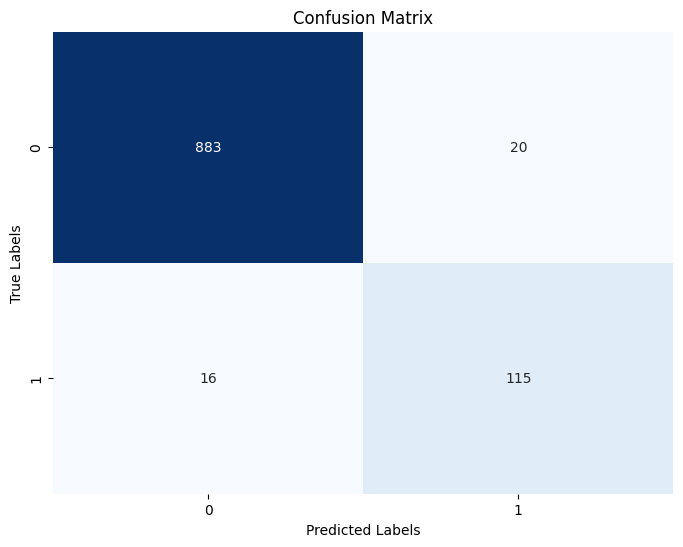

0.9223419258468035

In [ ]:
# Make predictions on the test set
print("Multinomial Naive Bayes - Without SMOTE")
y_pred = nb_model.predict(X_test)
compute_performance(y_test, y_pred)
print("Multinomial Naive Bayes - With SMOTE")
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = nb_model_smote.predict(X_test_tfidf)
compute_performance(y_test, y_pred)

Random Forest Classifier

Random Forest Classifier - Without SMOTE
Accuracy: 0.9738878143133463
Recall (macro): 0.9067358169967792
Precision (macro): 0.9733766233766235
F1 (macro): 0.9365942399280502


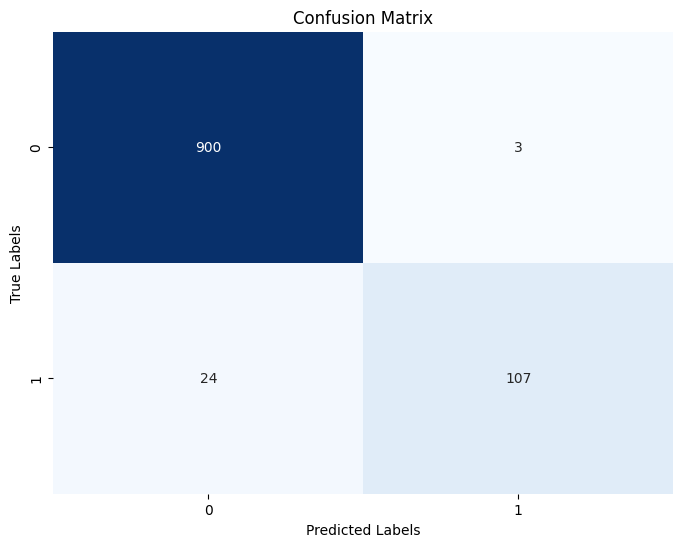

Random Forest Classifier - With SMOTE
Accuracy: 0.9748549323017408
Recall (macro): 0.9105526108899089
Precision (macro): 0.9740271148721853
F1 (macro): 0.9391616050980782


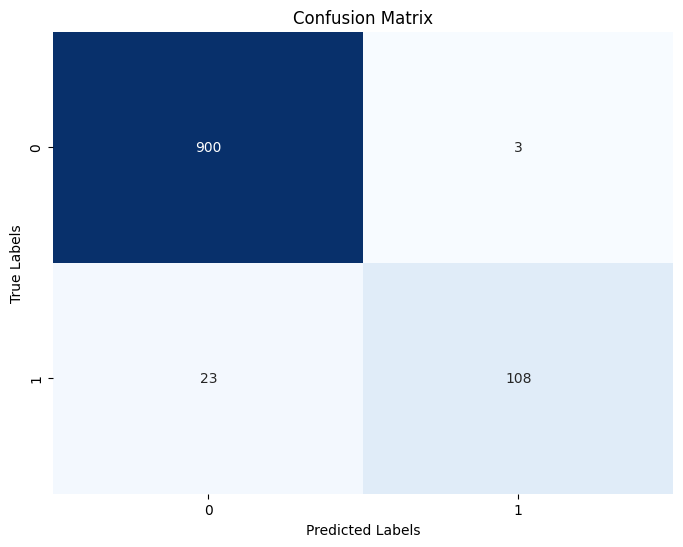

0.9391616050980782

In [ ]:
# Make predictions on the test set
print("Random Forest Classifier - Without SMOTE")
y_pred = rf_model.predict(X_test)
compute_performance(y_test, y_pred)
print("Random Forest Classifier - With SMOTE")
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = rf_model_smote.predict(X_test_tfidf)
compute_performance(y_test, y_pred)

# Saving Models

In [ ]:
import joblib
lr_pipeline = Pipeline([('vect',tfidf_vectorizer),
                    ('clf',lr_model_smote)])
rf_pipeline = Pipeline([('vect',tfidf_vectorizer),
                    ('clf',rf_model_smote)])
joblib.dump(lr_pipeline, 'lr_model.pkl')
joblib.dump(nb_model, 'nb_model.pkl')
joblib.dump(rf_pipeline, 'rf_model.pkl')

['rf_model.pkl']